In [29]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pandas as pd


In [50]:

dev_data_path = '/home/ashrafs/projects/dataset/FEVER-Processed/feverous_dev_challenges_statements.jsonl'
dev_graph_path = '/home/ashrafs/projects/dataset/FEVER-Processed/feverous_dev.pickle'

In [31]:

def load_data(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Load the data
data_list = load_data(dev_data_path)

# Now, data_list contains all the data from the JSONL file
# Count the claims
number_of_claims = len(data_list)


In [32]:
number_of_claims

7890

In [33]:
def count_statements_per_claim(data_list):
    claim_data = []
    for data in data_list:
        claim_text = data.get('CLAIM', 'No Claim Found')
        entity_statements = data.get('ENTITY_STATEMENTS', {})

        # Count the number of statements for the current claim
        statement_count = sum(len(details.get('statements', [])) for _, details in entity_statements.items()) if entity_statements is not None else 0

        # Store both the claim text and the count in a tuple
        claim_data.append((claim_text, statement_count))

    return claim_data


In [34]:
# Assuming data_list contains your loaded data
claim_data = count_statements_per_claim(data_list)

# Convert to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(claim_data, columns=['Claim', 'Statement Counts'])

# Now df contains both the claim text and the corresponding statement counts


In [35]:
df.head(5)


,Claim,Statement Counts
0,Algebraic logic has five Logical system and Li...,96
1,Aramais Yepiskoposyan played for FC Ararat Yer...,828
2,Scot's book is titled The Discoverie of Witchc...,194
3,Family Guy is an American animated sitcom that...,5822
4,"In John Laurie's partial television credits, h...",0


In [36]:
# Find the index of the maximum and minimum Statement Counts
max_index = df['Statement Counts'].idxmax()
min_index = df['Statement Counts'].idxmin()

# Retrieve the rows corresponding to these indices
max_statement_row = df.loc[max_index]
min_statement_row = df.loc[min_index]

# Display the results
print("Row with Maximum Statement Count:\n", max_statement_row, "\n")
print("Row with Minimum Statement Count:\n", min_statement_row)


Row with Maximum Statement Count:
 Claim               4 the People was one of Malaysia's trendiest a...
Statement Counts                                                86268
Name: 4160, dtype: object 

Row with Minimum Statement Count:
 Claim               In John Laurie's partial television credits, h...
Statement Counts                                                    0
Name: 4, dtype: object


In [38]:
max_statement_row['Claim']


"4 the People was one of Malaysia's trendiest and highest grossing films in part due to Best Music Director winner Jassie Gift."

In [39]:
# Descriptive statistics
summary_statistics = df['Statement Counts'].describe()
print("Descriptive Statistics for Statement Counts:\n", summary_statistics)


Descriptive Statistics for Statement Counts:
 count     7890.000000
mean      1015.247909
std       2719.366264
min          0.000000
25%          0.000000
50%        566.000000
75%       1388.000000
max      86268.000000
Name: Statement Counts, dtype: float64


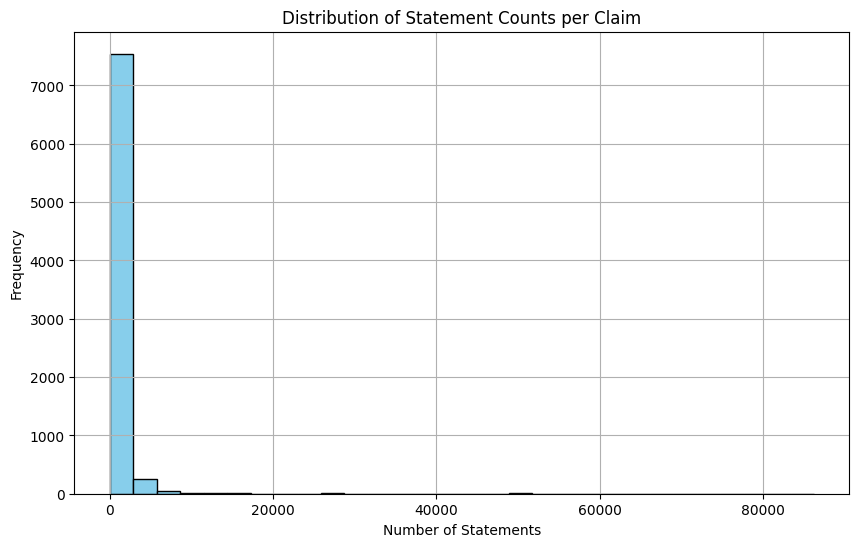

In [40]:
import matplotlib.pyplot as plt

# Histogram for statement counts
plt.figure(figsize=(10, 6))
plt.hist(df['Statement Counts'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Statement Counts per Claim')
plt.xlabel('Number of Statements')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [41]:
skewness = df['Statement Counts'].skew()
kurtosis = df['Statement Counts'].kurtosis()
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")


Skewness: 16.53180227537343
Kurtosis: 379.5474941315934


In [43]:
# Filter the DataFrame to get rows where 'Statement Counts' is 0
claims_with_zero_statements = df[df['Statement Counts'] == 0]

# Display these claims
print("Claims with Zero Statements:")
print(len(claims_with_zero_statements['Claim']))


Claims with Zero Statements:
2495


In [44]:
claims_with_zero_statements.head(5)

,Claim,Statement Counts
4,"In John Laurie's partial television credits, h...",0
5,"List of Once Upon a Time (debuted October 23, ...",0
8,Xiao Sha competed in the World Championships a...,0
9,"The Glenn–Thompson Plantation, a historic plan...",0
12,Harman Tarrant was a member of the first incar...,0


In [47]:
def is_fully_connected(G):
    return nx.is_connected(G) if G.number_of_nodes() > 1 else False

# Update here: Add an additional check for None
claims_with_statements = [data for data in data_list if data.get('ENTITY_STATEMENTS') is not None and sum(len(details.get('statements', [])) for _, details in data.get('ENTITY_STATEMENTS', {}).items()) > 0]

graphs_stats = []

for data in claims_with_statements:
    G = nx.Graph()  # Using an undirected graph; use nx.DiGraph() for a directed graph
    entity_statements = data.get('ENTITY_STATEMENTS', {})

    for _, details in entity_statements.items():
        for statement in details.get('statements', []):
            # Add edges between entities; this also adds the nodes
            G.add_edge(statement[0], statement[2])

    num_nodes = G.number_of_nodes()
    fully_connected = is_fully_connected(G)
    
    graphs_stats.append({'Claim': data.get('CLAIM'), 'Num_Nodes': num_nodes, 'Is_Fully_Connected': fully_connected})

# Convert the results to a DataFrame
stats_df = pd.DataFrame(graphs_stats)
print(stats_df)


                                                  Claim  Num_Nodes  \
0     Algebraic logic has five Logical system and Li...         41   
1     Aramais Yepiskoposyan played for FC Ararat Yer...        348   
2     Scot's book is titled The Discoverie of Witchc...         91   
3     Family Guy is an American animated sitcom that...       1859   
4     Per Axel Rydberg, born on July 6, 1860 in Odh,...       1694   
...                                                 ...        ...   
5390  Swedish Flower Hen is a traditional farmyard b...        244   
5391  The Eureka Transit Service, which has served E...          7   
5392  Basil King became an Anglican rector without e...        657   
5393  Fishing in India takes place in a exclusive ec...       1049   
5394  Oil City Symphony is a musical with a book by ...         36   

      Is_Fully_Connected  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

In [48]:
# Count of fully connected graphs
fully_connected_count = sum(1 for stat in graphs_stats if stat['Is_Fully_Connected'])

# Count of not fully connected graphs
not_fully_connected_count = sum(1 for stat in graphs_stats if not stat['Is_Fully_Connected'])

# Display the counts
print(f"Count of Fully Connected Graphs: {fully_connected_count}")
print(f"Count of Not Fully Connected Graphs: {not_fully_connected_count}")


Count of Fully Connected Graphs: 5364
Count of Not Fully Connected Graphs: 31


In [57]:

def is_fully_connected(G):
    return nx.is_connected(G.to_undirected()) if G.number_of_nodes() > 1 else False

claims_with_statements = [data for data in data_list if data.get('ENTITY_STATEMENTS') is not None and sum(len(details.get('statements', [])) for _, details in data.get('ENTITY_STATEMENTS', {}).items()) > 0]

graphs_stats = []

for data in claims_with_statements:
    G = nx.DiGraph()  # Using a directed graph
    entity_statements = data.get('ENTITY_STATEMENTS', {})

    for _, details in entity_statements.items():
        for statement in details.get('statements', []):
            # Add edges directly between entities, store relation as an edge attribute
            G.add_edge(statement[0], statement[2], relation=statement[1])

    num_nodes = G.number_of_nodes()
    fully_connected = is_fully_connected(G)
    
    graphs_stats.append({'Claim': data.get('CLAIM'), 'Num_Nodes': num_nodes, 'Is_Fully_Connected': fully_connected, 'Graph':G})

# Count of fully connected vs not fully connected graphs
fully_connected_count = sum(1 for stat in graphs_stats if stat['Is_Fully_Connected'])
not_fully_connected_count = sum(1 for stat in graphs_stats if not stat['Is_Fully_Connected'])

# Display the counts
print(f"Count of Fully Connected Graphs: {fully_connected_count}")
print(f"Count of Not Fully Connected Graphs: {not_fully_connected_count}")


Count of Fully Connected Graphs: 5364
Count of Not Fully Connected Graphs: 31


In [58]:

# Save the list of graphs to a file
with open(dev_graph_path, "wb") as f:
    pickle.dump(graphs_stats, f)


In [59]:
# Load the graphs from the file
with open(dev_graph_path, "rb") as f:
    loaded_graphs_stats = pickle.load(f)


In [60]:
# Print the keys of the first dictionary in loaded_graphs_stats
print(loaded_graphs_stats[0].keys())


dict_keys(['Claim', 'Num_Nodes', 'Is_Fully_Connected', 'Graph'])


In [63]:
len(loaded_graphs_stats)

5395

In [70]:
loaded_graphs_stats[50]

{'Claim': 'Psathyrotes ramosissima is a species of flowering plant that is a part of the plantae family and belongs to the asteraceae family known by the common name turtleback.',
 'Num_Nodes': 49,
 'Is_Fully_Connected': True,
 'Graph': <networkx.classes.digraph.DiGraph at 0x7f3f5722ec10>}

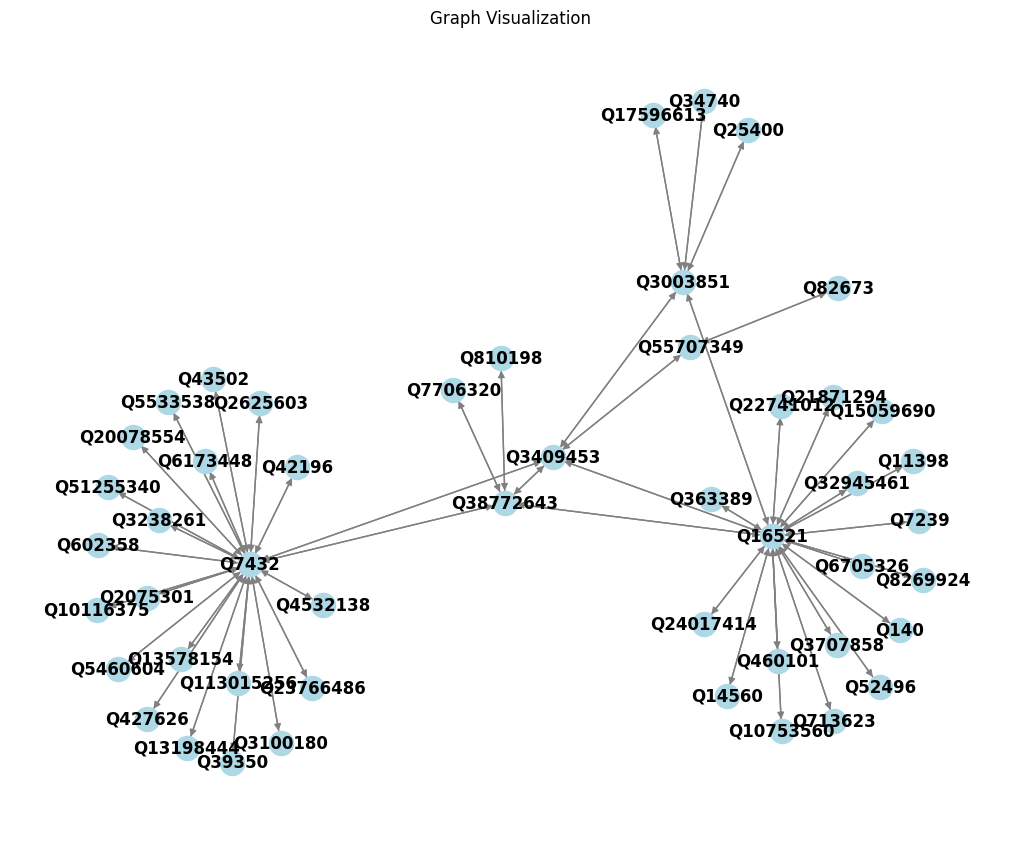

In [71]:
# Extract the first graph for demonstration purposes
example_graph = loaded_graphs_stats[50]['Graph']  # Replace 'Graph' with the actual key used for the graph
plt.figure(figsize=(10, 8))
nx.draw(example_graph, with_labels=True, node_color='lightblue', edge_color='gray', font_weight='bold')
plt.title("Graph Visualization")
plt.show()